### Using the `findiff` package
In 1D, the Fokker Planck operator for the symmetric-$\alpha$-stable driven Langevin equation reads:
$$ (\mathcal{L}u)(x) = \frac{1}{\gamma m} \frac{\partial}{\partial x}\left[u(x)\frac{\partial}{\partial x}V(x)\right] + D \frac{\partial^{\alpha}}{\partial x^{\alpha}}u(x)$$
 
Fourier-transforming and with the assumption that $V(x) := \sum_{n = 1}^{p}\frac{t_{n}}{n}x^{n}$,

$$(\mathcal{L}u)(k) = \frac{1}{\gamma m}\sum_{n=1}^{p} \frac{t_{n}}{(-i)^{n}}k\frac{\partial^{n-1}}{\partial k^{n-1}}u(k) - D |k|^{\alpha}u(k)$$

In [1]:
import numpy as np
from findiff import Identity, FinDiff, Coefficient
import scipy.sparse
import scipy.linalg
from scipy.integrate import romb
import matplotlib.pyplot as plt

In [2]:
def n_th_derivative(n:int, dx:float):
    if n == 0:
        return Identity()
    else:
        return FinDiff(0, dx, n)

def inverse_fourier_transform(f, k, x):
    phase = np.exp(1j*x[:, None]*k[None, :]) #(x, k)
    f_phase = phase[..., None]*f[None, ...] #(x, k, f)
    return romb(f_phase, dx=k[1] - k[0], axis=1)

def standardize_phase(lfn, rfn):
    abs_max_idx = np.argmax(np.abs(rfn))
    phase = np.angle(rfn[abs_max_idx])
    return lfn*np.exp(-1j*phase), rfn*np.exp(-1j*phase)

In [3]:
def fokker_planck_fourier(k, potential_coeffs, gamma, noise_intensity, alpha=2):
    dk = k[1] - k[0]
    exponents = -np.arange(len(potential_coeffs), dtype=int) -1
    phases = np.power(-1j, exponents)
    coeffs = phases*potential_coeffs*(gamma**-1)
    
    L = -1.0*noise_intensity*scipy.sparse.diags(np.abs(k)**alpha)
    
    _findiff_op = Coefficient(k*coeffs[0])*n_th_derivative(0, dk)
    for i, c in enumerate(coeffs):
        if i > 0:
            _findiff_op = _findiff_op + Coefficient(c*k)*n_th_derivative(i, dk)
    L += _findiff_op.matrix(k.shape)
    L = L.toarray()
    assert np.max(np.abs(L.imag)) < 1e-10
    return L.real

### Bistable potential

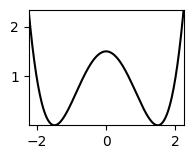

In [4]:
depth = 1.5
width = 1.5
h = 4*depth/(width**2)
g = 4*depth/(width**4)

bistable_coeffs = [0, -h, 0, g]

#Plotting it
_np_coeffs = np.array(bistable_coeffs)*(np.arange(1, len(bistable_coeffs) + 1, dtype=float)**-1)
_np_coeffs = np.insert(_np_coeffs, 0, 0)
bistable_potential = np.polynomial.Polynomial(_np_coeffs)

fig, ax = plt.subplots(figsize=(2, 1.5))
x_sample = np.linspace(-width*1.5, width*1.5, 250)
ax.plot(x_sample, bistable_potential(x_sample) + depth, 'k-')
ax.margins(0)

In [5]:
gamma = 0.1
noise_intensity = 1.0
alpha = 1.5

dk = 0.5/(width)

num_pts = 2**10 + 1

k_bound = dk*(num_pts - 1)/2
k = np.linspace(-k_bound, k_bound, num_pts)

In [6]:
L = fokker_planck_fourier(k, bistable_coeffs, gamma, noise_intensity, alpha=alpha)

In [7]:
_Q, _lv, _rv = scipy.linalg.eig(L, left=True, right=True)

In [8]:
stable_evals = (_Q.real <= 0)
Q = _Q[stable_evals]
lv = _lv[:, stable_evals]
rv = _rv[:, stable_evals]
#Sorting by real part
sort_perm = np.flip(np.argsort(Q.real))
Q = Q[sort_perm]
lv = lv[:, sort_perm]
rv = rv[:, sort_perm]

[Text(0.5, 0, '$k$')]

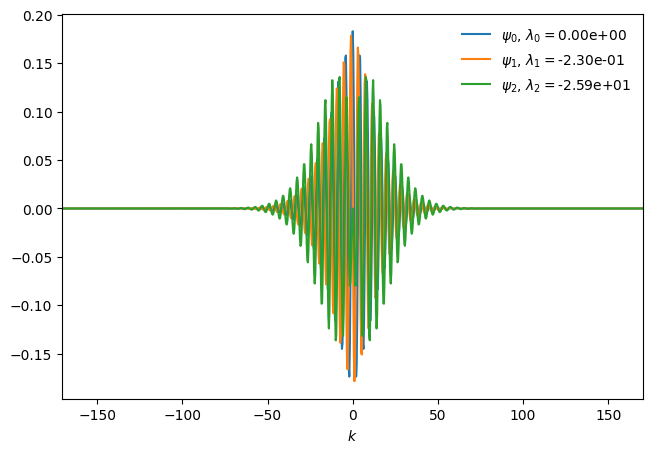

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(7.5, 5))
settings = {
    'xlabel': r"$k$",
}
for i in range(3):
    ax.plot(k, rv[:, i].real, label=r"$\psi_" + f'{i}' + r"$, $\lambda_{" + f'{i}' + r"} = $" + f'{Q[i].real:.2e}')
ax.legend(frameon=False, loc='upper right')
ax.margins(x=0)
ax.set(**settings)

In [10]:
lv_x = inverse_fourier_transform(lv, k, x_sample)
rv_x = inverse_fourier_transform(rv, k, x_sample)

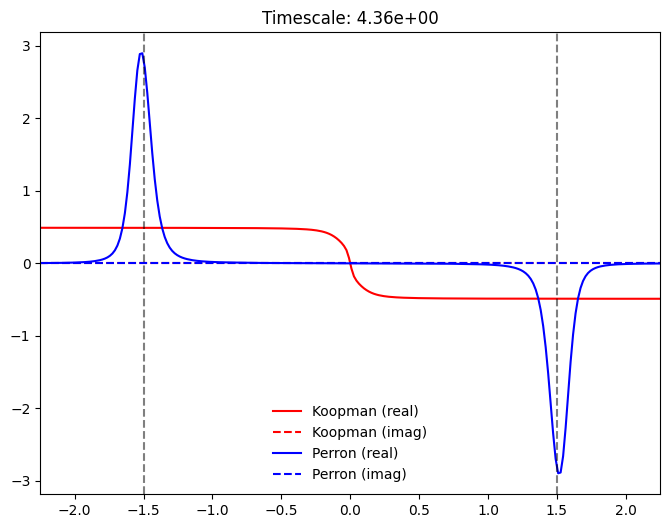

In [11]:
fun_idx = 1

lfn = lv_x[:, fun_idx]
rfn = rv_x[:, fun_idx]
lfn, rfn = standardize_phase(lfn, rfn)

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(x_sample, lfn.real, 'r-', ms=1.0, label='Koopman (real)')
ax.plot(x_sample, lfn.imag, 'r--', label='Koopman (imag)')
ax.plot(x_sample, rfn.real, 'b-', ms=0.1, label='Perron (real)')
ax.plot(x_sample, rfn.imag, 'b--', label='Perron (imag)')
ax.axvline(-width, color='k', ls='--', alpha=0.5)
ax.axvline(width, color='k', ls='--', alpha=0.5)
if Q[fun_idx].real < 0:
    ax.set_title(f"Timescale: {-(Q[fun_idx].real)**-1:.2e}")
elif Q[fun_idx].real > 0:
    ax.set_title("Unstable")
else:
    ax.set_title(r"Timescale: $\infty$")
ax.legend(frameon=False)
ax.margins(x=0)